# Capstone 2 Project - Russian Troll Tweets NLP

### Initial tweet data exploration
First, I'll join together all of the tweet data, reading and joining all of the 13 data files

I will use the Tweets to explore questions about the nature of the disinformation campaign, such as:
* Did other trolls retweet and amplify troll tweets?
* Can common topics or themes be identified?
* What were the most-used hashtags?
* Did the tweets predominantly support one candidate or political party, or seek to undermine the other?

After the analysis of the entire set of troll tweets, I will segment the troll classes and analyze each individually.  The "troll classes", as defined by Clemson University's Darren Linvill and Patrick Warren in their analysis of the Russian Troll Farm Twitter data.

## Data Dictionary

Header | Definition
-------|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?   id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018

In [1]:
# import standard libraries
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#import numpy as np
#import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
#get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# import nltk libraries
from nltk.corpus import stopwords
from nltk import FreqDist
#nltk.download('stopwords') # run one time

In [3]:
# import gensim libraries
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import datapath
from gensim import corpora
from gensim.utils import any2unicode

In [4]:
# Read in the cleaned
df = pd.read_csv('../data/all_IRAhandle_tweets.csv', parse_dates = ['publish_date', 'harvested_date'], encoding='utf-8',low_memory=False)
# print(df.shape)

In [5]:
#df.drop('Unnamed: 0', axis=1, inplace=True)
# drop rows with problematic character encoding
df.drop([58, 59], axis=0, inplace=True)

In [6]:
df['cleaned'] = df['content'].fillna('').astype(str).map(any2unicode)

## Text Preprocessing
* Noise Removal
* Tokenization
* Normalization  
(1) stemming
(2) lemmatization, and 
(3) everything else

### Remove URLs and non-English Characters

In [7]:
def preprocess_text(text):
    '''Remove URLs and Non-English characters, except for @ and #'''
    # remove URL's
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    # remove symbols excluding the @, # and \s symbol
    text = re.sub(r'[^\w@#\s]', '', text)

    # remove URL's
    text = re.sub('(https://[^\s]+)', '', text)
    text = re.sub('https?://[A-Za-z0-9./]+', '', text)

    # remove URL's
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)

    # lowercase, remove words less than len 2 & remove numbers in tokenized list
    #return [word.lower() for word in text if len(word) > 2 and not word.isdigit() and not word in ignore_words]
    return text

In [8]:
df['cleaned'] = df['cleaned'].apply(preprocess_text)

### Hashtag Analysis

In [9]:
# regex to find hashtags
hashtag_re = re.compile("(?:^|\s)[＃#]{1}(\w+)", re.UNICODE)

def extract_hashtags(tweet):
    '''Take in tweet contents from 'cleaned' content, extract hashtags and return cleaned text'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        hashtags_only.append(re.findall(hashtag_re, tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

In [10]:
# Create a new column to store hashtags, extract hashtags from 'content'
df['hashtags'] = df['cleaned'].map(extract_hashtags)
df['hashtags'].head(25)

0                     [0]
1                     [0]
2            [BoycottNFL]
3                     [0]
4     [StandForOurAnthem]
5                     [0]
6                     [0]
7                     [0]
8                     [0]
9                     [0]
10                    [0]
11                    [0]
12                    [0]
13                    [0]
14                    [0]
15                    [0]
16                    [0]
17                    [0]
18                    [0]
19                    [0]
20                    [0]
21                    [0]
22                    [0]
23                    [0]
24         [HipHopAwards]
Name: hashtags, dtype: object

In [11]:
# remove all hashtags from a tweet
def remove_hashtags(tweet):
    '''After extracting hashtags, take in tweet content and remove hashtags'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        tweet = re.sub(hashtag_re, "", tweet)
    hashtags_only.append(tweet)
    return hashtags_only[0]

In [12]:
# Clean hashtags fron 'cleaned' content
df['cleaned'] = df['cleaned'].apply(remove_hashtags)

In [13]:
# create a list of all hashtags
all_hashtags = df['hashtags'].tolist()

# all_hashtags is a list of lists.
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_hashtags list
cleaned_hashtags = remove_values_from_list(cleaned_hashtags, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()
print(hashtag_counts[:25])

0                    1816120
news                  128754
sports                 48641
politics               39744
world                  27558
local                  25890
TopNews                15149
MAGA                   14701
BlackLivesMatter       11950
health                 11486
tcot                   11447
business               10850
PJNET                  10401
новости                10315
tech                    8232
entertainment           7586
top                     7417
Cleveland               6695
TopVideo                6547
crime                   6505
ISIS                    6036
Merkelmussbleiben       5818
environment             5785
Trump                   5741
NowPlaying              5395
dtype: int64


### Get User Mentions

In [14]:
#Regex to get user mentions "@":
twitter_username_re = re.compile("(?:^|\s)[＠ @]{1}([^\s#<>[\]|{}]+)", re.UNICODE)

def extract_usermentions(tweet):
    '''Take in tweet contents from 'cleaned' col and extract user mentions'''
    mentions_only = []
    if len(re.findall(twitter_username_re, tweet)) > 0:
        mentions_only.append(re.findall(twitter_username_re, tweet))
    else:
        mentions_only.append(["0"])
    return mentions_only[0]

In [15]:
# make a new column to store the extracted mentions
df['mentions'] = df['cleaned'].map(extract_usermentions)
df['mentions'].head(10)

0                            [@nedryun]
1                                   [0]
2                                   [0]
3                                   [0]
4                                   [0]
5                                   [0]
6                                   [0]
7    [SenatorMenendez, CarmenYulinCruz]
8                                   [0]
9                                 [CNN]
Name: mentions, dtype: object

In [18]:
# create a list of all mentions
all_mentions = df['mentions'].tolist()

# all_hashtags is a list of lists.
cleaned_mentions = []
for i in all_mentions:
    for j in i:
            cleaned_mentions.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_mentions list
cleaned_mentions = remove_values_from_list(cleaned_mentions, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_mentions_series = pd.Series(cleaned_mentions)
mention_counts = cleaned_mentions_series.value_counts()
# remove first element with values of '0'
# mention_counts = del mention_counts[0]
print(mention_counts[:25])

0                  1883327
I                    27092
via                  23618
RT                   18887
The                  12654
realDonaldTrump      12457
YouTube               8940
midnight              7263
Trump                 6651
BREAKING              6479
Im                    5517
the                   5250
POTUS                 4931
is                    4578
You                   4516
с                     4478
CNN                   4460
A                     4428
HillaryClinton        4085
This                  3937
and                   3814
We                    3599
AP                    3296
you                   3271
a                     3231
dtype: int64


In [19]:
# remove all mentions from a tweet
def remove_mentions(tweet):
    '''Take tweet content and remove @mentions from it'''
    mentions_only = []
    if len(re.findall("(@[^@\s]+)", tweet)) > 0:
        tweet = re.sub("(@[^@\s]+)", "", tweet)
    mentions_only.append(tweet)
    return mentions_only[0]

In [20]:
#create list of content with no hashtags
df['cleaned'] = df['cleaned'].apply(remove_mentions)

In [21]:
# remove unwanted characters, numbers and symbols from the remaining content
#df['cleaned'] = df['cleaned'].str.replace("[^a-zA-Z#]", " ")

### Create dataframes for the troll classifications
Create dataframes for each troll classification, for easier size to work with.

In [22]:
#right_troll = df.loc[df['account_category'] == 'RightTroll']
#nonenglish = df.loc[df['account_category'] == 'NonEnglish']
#fearmonger = df.loc[df['account_category'] == 'Fearmonger']
#left_troll = df.loc[df['account_category'] == 'LeftTroll']
#hashtagamer = df.loc[df['account_category'] == 'HashtagGamer']
#newsfeed = df.loc[df['account_category'] == 'NewsFeed']
#commercial = df.loc[df['account_category'] == 'Commercial']

In [23]:
#right_troll.to_csv("../data/right_troll.csv")
#nonenglish.to_csv("../data/nonenglish.csv")
#fearmonger.to_csv("../data/fearmonger.csv")
#left_troll.to_csv("../data/left_troll.csv")
#hashtagamer.to_csv("../data/hashtagamer.csv")
#newsfeed.to_csv("../data/newsfeed.csv")
#commercial.to_csv("../data/commercial.csv")

## Remove stopwords
Remove words < 3 letters, convert to lower case

In [24]:
# remove short words (length < 3)
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# transform to lower-case
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#train['tweet'].head()

#stop = set(stopwords.words('english'))
stop = stopwords.words('english')

#extend/add to stopwords - words that are commonly occuring but add no meaning
#stopword_list += ['http', 'https', 'âµã', 'â½ã', 'â²ã', 'âºã', 'â¼ã', 'âµ']
newStop = ['you','get', 'amp', 'one', 'new']
stop.extend(newStop)

df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['cleaned'].head()

0                  sitting democrat senator trial corruption youve barely heard peep mainstream media
1              marshawn lynch arrives game antitrump shirt judging sagging pants shirt say lynch belt
2      daughter fallen navy sailor delivers powerful monologue anthem protests burns nfl packers gear
3    president trump dedicates presidents cup golf tournament trophy people florida texas puerto rico
4                                                                    19000 respecting national anthem
Name: cleaned, dtype: object

In [25]:
#convert 'cleaned' Series to a list
content = df['cleaned'].tolist()
#content[:50]

### Re-Check Fequency Distribution
Re-check the word frequency distribution after doing some cleaning of the text.

In [26]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    ''' Take in a list of content, split into individual words, count occurrences, list 20 highest occurring words'''
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    return d

In [27]:
counts = freq_words(content, 20)
print(counts)

            word   count
36         trump  128083
500       police   57291
481          man   54601
43        people   53098
259         like   45837
191         dont   44280
31154    workout   41780
120        obama   39657
603        black   38324
479        video   37661
698         says   36056
1700      россии   31077
1971         via   31037
447        white   30707
590         time   30254
35     president   30063
135     breaking   29862
542          day   29860
149      hillary   29809
1644         что   29690


### Plot most frequently occurring words 

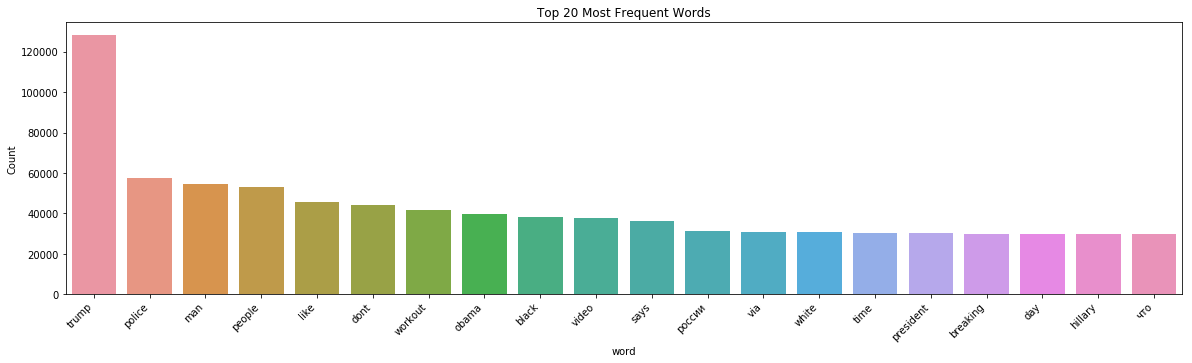

In [28]:
# Plot most frequent words
plt.figure(figsize=(20,5))
# rotate and right align group names
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(data=counts, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Top 20 Most Frequent Words')    
plt.show()

## Troll Amplification
Examining the troll "echo chamber". Are trolls retweeting or mentioning other trolls?

In [29]:
# read list of users created during EDA
users = pd.read_csv('../data/users_totals.csv', encoding='utf-8',low_memory=False)

userlist = users['author'].tolist()
lc_userlist = [x.lower() for x in userlist]
lc_userlist.sort()

amplify = cleaned_mentions_series[cleaned_mentions_series.isin(lc_userlist)]

print(amplify.shape[0])

# Get counts of amplified troll tweets
amp_counts = amplify.value_counts()
print("There are",(amplify.shape[0]), "trolls in the echo chamber.")

1752
There are 1752 trolls in the echo chamber.


### Normalization
3 distinct steps:  
* stemming  
* lemmatization  
* everything else

### Lemmatization

In [30]:
from textblob import Word
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['cleaned'].head()

0                sitting democrat senator trial corruption youve barely heard peep mainstream medium
1              marshawn lynch arrives game antitrump shirt judging sagging pant shirt say lynch belt
2        daughter fallen navy sailor delivers powerful monologue anthem protest burn nfl packer gear
3    president trump dedicates president cup golf tournament trophy people florida texas puerto rico
4                                                                   19000 respecting national anthem
Name: cleaned, dtype: object

### Tokenize

In [31]:
#create a list from df['cleaned']
content_notags = df['cleaned'].tolist()

# First, create a new column with the tokenized text
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
#df['tokenized_text'] = df['content'].apply(tt.tokenize)
# map tt.tokenize to 'content' list
documents = list(map(tt.tokenize, content_notags))

In [32]:
from collections import defaultdict

frequency = defaultdict(int)
for document in documents:
    for token in document:
        frequency[token] += 1

In [33]:
documents = [[token for token in document if frequency[token] > 10] for document in documents]
# create a dictionary using from gensim.corpora.Dictionary
dictionary = corpora.Dictionary(documents)
#Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 
corpus = [dictionary.doc2bow(document) for document in documents]

In [34]:
len(corpus)

2946205

## LDA Model
Fit an LDA Model for the tweet topics

In [38]:
# comment out once model is trained.
# fit LDA model
tweet_topics = LdaMulticore(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          passes=10,
                          workers=2)

In [39]:
# save/load model to/from disk

temp_file = datapath("model_all_rus_tweets")
tweet_topics.save(temp_file)

# Load a pretrained model from disk.
#tweet_topics = LdaMulticore.load("model")
# - or -
#m1 = LdaMulticore.load(datapath("lda_3_0_1_model"))

<function datapath at 0x1a19266c80>


In [40]:
# print out first 10 topics
for i, topic in enumerate(tweet_topics.print_topics(10)):
    print('{} --- {}'.format(i, topic))

0 --- (0, '0.043*"police" + 0.039*"man" + 0.016*"woman" + 0.012*"shot" + 0.011*"ohio" + 0.011*"officer" + 0.010*"suspect" + 0.009*"school" + 0.009*"bill" + 0.009*"found"')
1 --- (1, '0.041*"trump" + 0.013*"obama" + 0.013*"hillary" + 0.013*"clinton" + 0.011*"president" + 0.009*"say" + 0.009*"american" + 0.008*"donald" + 0.007*"vote" + 0.007*"state"')
2 --- (2, '0.022*"фото" + 0.008*"court" + 0.008*"jersey" + 0.007*"lada" + 0.006*"long" + 0.006*"города" + 0.006*"und" + 0.006*"россию" + 0.006*"season" + 0.005*"armed"')
3 --- (3, '0.015*"сша" + 0.015*"россии" + 0.015*"сирии" + 0.007*"помощью" + 0.007*"против" + 0.007*"санкции" + 0.006*"путин" + 0.006*"россия" + 0.006*"для" + 0.005*"районе"')
4 --- (4, '0.013*"arizona" + 0.012*"black" + 0.011*"people" + 0.007*"love" + 0.006*"life" + 0.006*"best" + 0.006*"week" + 0.006*"woman" + 0.006*"hit" + 0.006*"white"')
5 --- (5, '0.014*"like" + 0.014*"dont" + 0.010*"know" + 0.010*"make" + 0.009*"philly" + 0.009*"people" + 0.008*"good" + 0.008*"need" + 

### Wordcloud
Crate a basic word cloud of the topic groupings

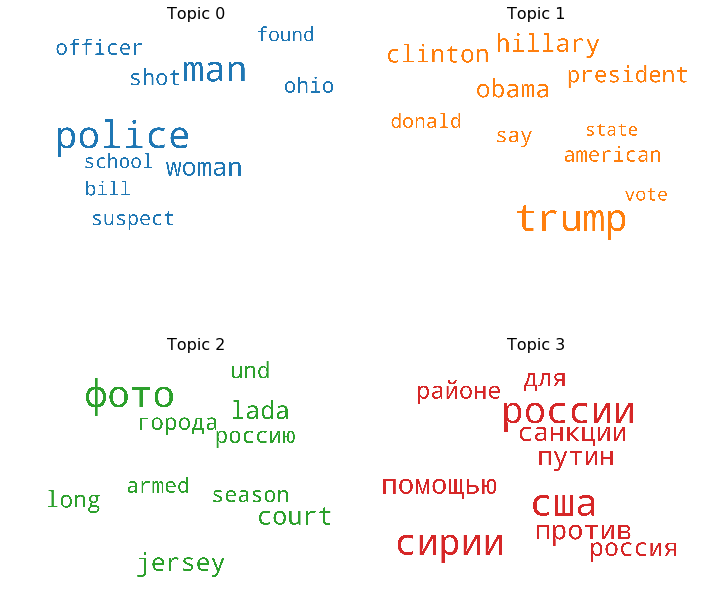

In [41]:
#Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = tweet_topics.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Use pyLDAvis library to Visualize Topics

In [42]:
## Try the pyLDAvis visualization
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [43]:
got# http://tlfvincent.github.io/2015/10/23/presidential-speech-topics/#topic=1&lambda=1&term=
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/admin/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Output Visualization Tool to HTML

In [45]:
# save viz output to an HTML file
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)

pyLDAvis.save_html(vis_data, 'pyLDAviz_all-topics_040519.html')

### Next, examine the hashtags and topics of each troll group
Analyze the hashtags, mentions, and topics of each of the seven "troll classes", as defined by Clemson University's Darren Linvill and Patrick Warren in their analysis of the Russian Troll Farm Twitter data.